<h1>Credit Card Lead Prediction</h1>

<h2>Problem Statement</h2>

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.

The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

* Customer details (gender, age, region etc.)
* Details of his/her relationship with the bank (Channel_Code, Vintage, Avg_Asset_Value etc.)

<h1>Import Libraries</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency, chi2


# Model Building
from sklearn.naive_bayes import GaussianNB                                 # Naive Bayes
from sklearn.linear_model import LogisticRegression                        # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier                         # KNN
from sklearn.tree import DecisionTreeClassifier                            # Decision Tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier    # Random Forest, AdaBoost

# Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

# -------------------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all' 

import winsound
duration=2000    # milliseconds
freq=440         # Hz
# winsound.Beep(freq,duration)         # Use this command wherever required for alarm

# Exploratory Data Analysis

In [2]:
# Load the data set
data = pd.read_csv('train_s3TEQDk.csv')

# Check the dimension of data set
data.shape
data.head()

(245725, 11)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [3]:
# Check datatype of each variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [4]:
# Summary of continuous variables
data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [5]:
# Summary of categorical variables
data.describe(include='object')

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
count,245725,245725,245725,245725,245725,216400,245725
unique,245725,2,35,4,4,2,2
top,DK9KC3DE,Male,RG268,Self_Employed,X1,No,No
freq,1,134197,35934,100886,103718,144357,150290


The ID column has unique ID for all the customers, so this does not give any information for prediction of lead.
Hence we delete this column.

In [6]:
# Delete 'ID' column 
data.drop('ID',axis=1,inplace=True)
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [7]:
# Check for missing values in data set
data.isnull().sum()/data.shape[0] *100

Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

Here, Credit_Product is the only variable with 11.9% missing values. Deleting these missing values would result in a lot of information being lost. So, these values need to be imputed. Being categorical variable, the obvious choice is imputation with modal value. But imputation with modal value changes the distribution of the data, so other method of imputation must be implemented. Here, the values will be imputed with KNN imputaion, for which all the variables must be numeric as KNN imputer uses distance function for imputation. Before imputation let's explore the dataset.  

# Data Visualization

## Exploring Continuous Variables

In [8]:
# Continuous features
conti_features = data.select_dtypes(exclude=object).columns
conti_features
data[conti_features].head()

Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead'], dtype='object')

,Age,Vintage,Avg_Account_Balance,Is_Lead
0,73,43,1045696,0
1,30,32,581988,0
2,56,26,1484315,0
3,34,19,470454,0
4,30,33,886787,0


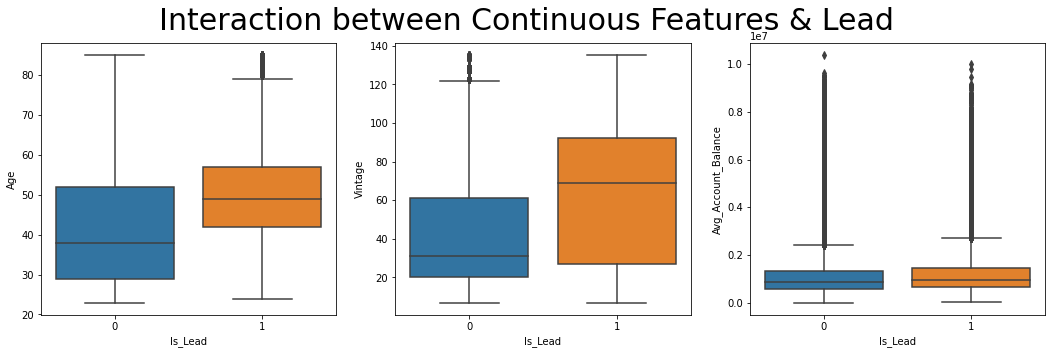

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.suptitle("Interaction between Continuous Features & Lead", fontsize=30, fontweight=15)

sns.boxplot(x="Is_Lead", y="Age", data=data, ax=axes[0]);
sns.boxplot(x="Is_Lead", y="Vintage", data=data, ax=axes[1]);
sns.boxplot(x="Is_Lead", y="Avg_Account_Balance", data=data, ax=axes[2]);

The above plot shows that all the variables are positively skewed with little or no ouliers as such except for the variable 'Avg_Account_Balance' which has many outliers.

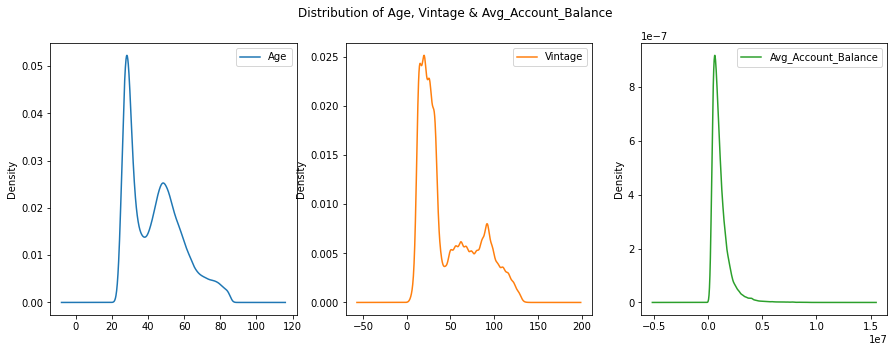

In [10]:
# Distribution of continuous variables
data[conti_features[:-1]].plot(kind='density', subplots=True, layout=(1,3), figsize=(15,5), sharex=False, sharey=False, 
                           title="Distribution of Age, Vintage & Avg_Account_Balance")
plt.show();

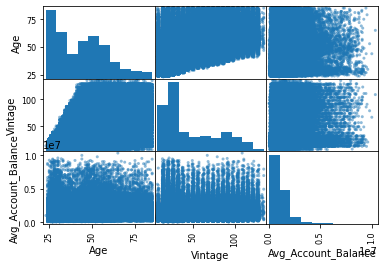

In [11]:
# Scatter plot of continuous variables
from pandas.plotting import scatter_matrix
scatter_matrix(data[conti_features[:-1]])
plt.show();

There seems to be some positive correlation between Age & Vintage. Let's verify.

In [12]:
# Correlations between continuous variables
print("Correlation(Age,Vintage) :",data['Age'].corr(data['Vintage']))
print("Correlation(Vintage,Avg_Account_Balance) :",data['Vintage'].corr(data['Avg_Account_Balance']))
print("Correlation(Age,Avg_Account_Balance) :",data['Age'].corr(data['Avg_Account_Balance']))

Correlation(Age,Vintage) : 0.6312424108308892
Correlation(Vintage,Avg_Account_Balance) : 0.1674334806418924
Correlation(Age,Avg_Account_Balance) : 0.14523218931496767


Here, it is verified that 'Age' & 'Vintage' are positively correlated with corr=0.63, but the correlation is not too high that one of them can be deleted to avoid the problem of multicollinearity.

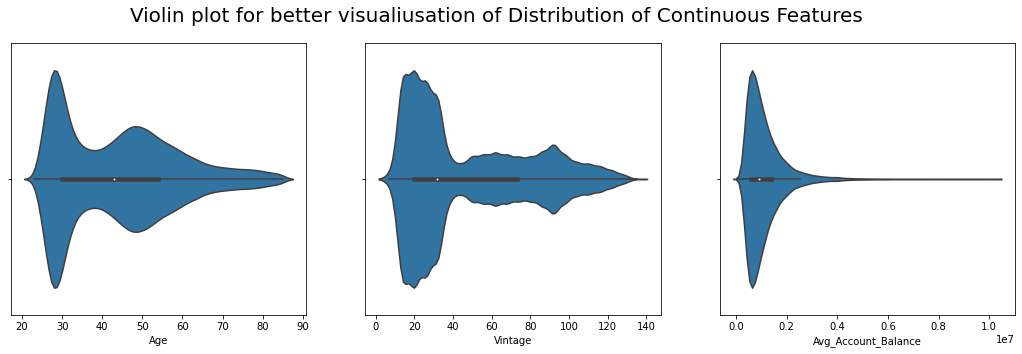

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.suptitle("Violin plot for better visualiusation of Distribution of Continuous Features", fontsize=20, fontweight=15)

sns.violinplot(x=data.Age, ax=axes[0]);
sns.violinplot(x=data.Vintage, ax=axes[1]);
sns.violinplot(x=data.Avg_Account_Balance, ax=axes[2]);

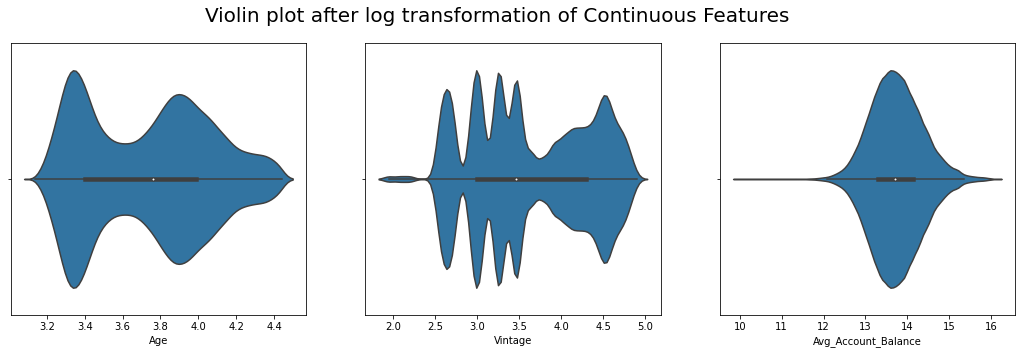

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.suptitle("Violin plot after log transformation of Continuous Features", fontsize=20, fontweight=15)

dis_age = np.log(data.Age)
dis_vin = np.log(data.Vintage)
dis_aab = np.log(data.Avg_Account_Balance)


sns.violinplot(x=dis_age, ax=axes[0]);
sns.violinplot(x=dis_vin, ax=axes[1]);
sns.violinplot(x=dis_aab, ax=axes[2]);

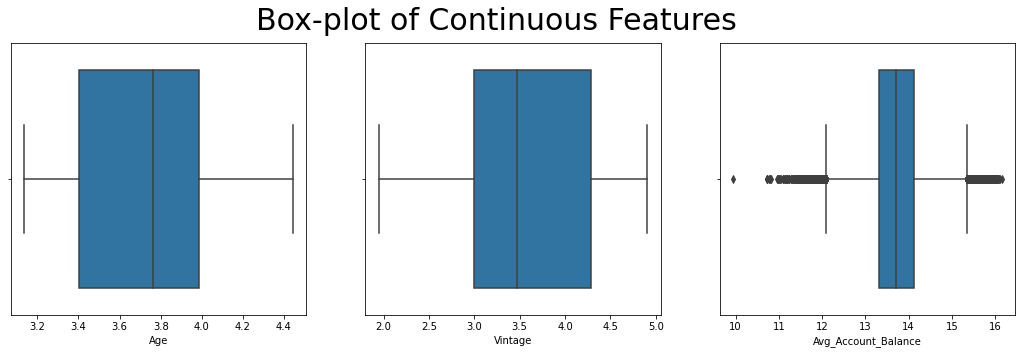

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.suptitle("Box-plot of Continuous Features", fontsize=30, fontweight=15)

sns.boxplot(x=dis_age, ax=axes[0]);
sns.boxplot(x=dis_vin, ax=axes[1]);
sns.boxplot(x=dis_aab, ax=axes[2]);

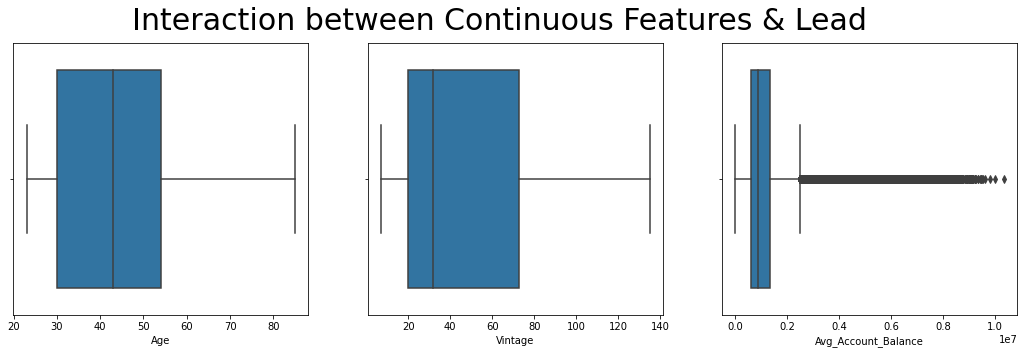

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
fig.suptitle("Interaction between Continuous Features & Lead", fontsize=30, fontweight=15)

sns.boxplot(x="Age", data=data, ax=axes[0]);
sns.boxplot(x="Vintage", data=data, ax=axes[1]);
sns.boxplot(x="Avg_Account_Balance", data=data, ax=axes[2]);

## Exploring Categorical Variables

In [17]:
# Extract all categorical features
categ_features = data.select_dtypes(include=object).columns
categ_features

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active'],
      dtype='object')

In [18]:
# Number of Males & Females
data.Gender.value_counts()

Male      134197
Female    111528
Name: Gender, dtype: int64

In [19]:
# Number of Active & Inactive customers
data.Is_Active.value_counts()

No     150290
Yes     95435
Name: Is_Active, dtype: int64

In [20]:
# Number of customers with & without Credit Product
data.Credit_Product.value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [21]:
# Number of unique Region_Code
print(data.Region_Code.unique())
print(data.Region_Code.value_counts().shape)

['RG268' 'RG277' 'RG270' 'RG282' 'RG261' 'RG265' 'RG283' 'RG254' 'RG269'
 'RG257' 'RG279' 'RG280' 'RG252' 'RG284' 'RG259' 'RG281' 'RG258' 'RG266'
 'RG260' 'RG274' 'RG256' 'RG275' 'RG273' 'RG267' 'RG272' 'RG251' 'RG262'
 'RG264' 'RG278' 'RG276' 'RG263' 'RG250' 'RG255' 'RG253' 'RG271']
(35,)


In [22]:
# Occupation of customers & their number
data.Occupation.value_counts()

Self_Employed    100886
Salaried          71999
Other             70173
Entrepreneur       2667
Name: Occupation, dtype: int64

In [23]:
# Unique Channel code & their counts
data.Channel_Code.value_counts()

X1    103718
X3     68712
X2     67726
X4      5569
Name: Channel_Code, dtype: int64

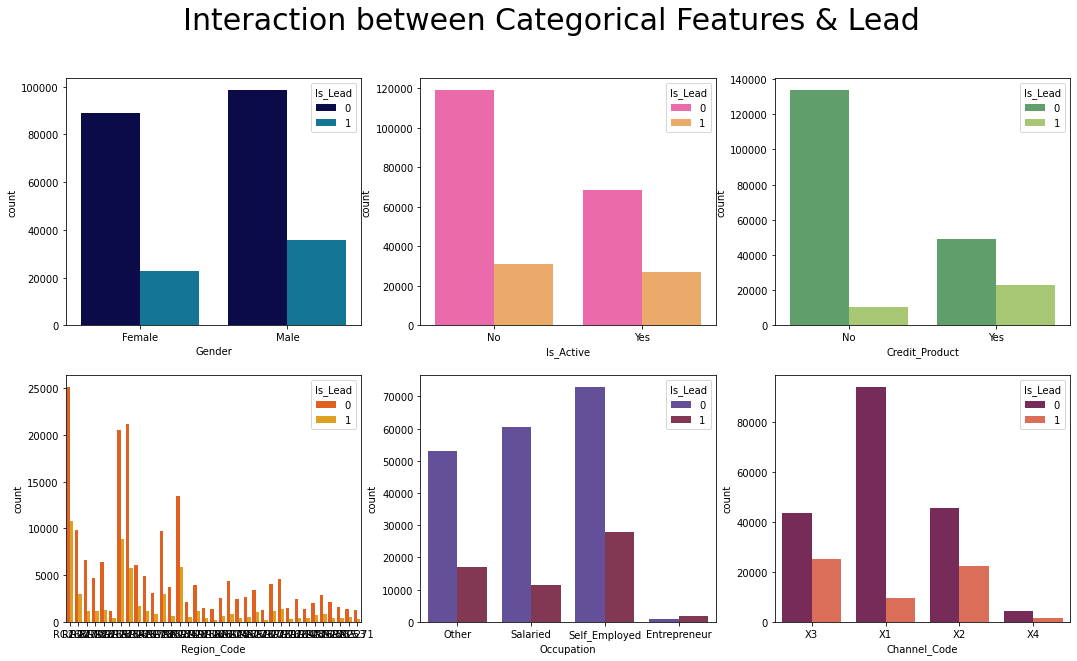

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
fig.suptitle("Interaction between Categorical Features & Lead", fontsize=30, fontweight=15)

sns.countplot(data.Gender,hue=data.Is_Lead, ax=axes[0,0], palette='ocean');
sns.countplot(data.Is_Active,hue=data.Is_Lead, ax=axes[0,1], palette='spring');
sns.countplot(data.Credit_Product,hue=data.Is_Lead, ax=axes[0,2], palette='summer');
sns.countplot(data.Region_Code,hue=data.Is_Lead, ax=axes[1,0], palette='autumn');
sns.countplot(data.Occupation,hue=data.Is_Lead, ax=axes[1,1], palette='twilight');
sns.countplot(data.Channel_Code,hue=data.Is_Lead, ax=axes[1,2], palette='rocket');

# Encoding Categorical Variable

## Testing significance of 'Region Code'

**Significance of Region_Code**

The variable 'Region_Code' has 35 unique categories, so encoding them as dummy variables would create 34 new variables which increases the dimension and might also hamper the model performance due to sparse data. Frequency encoding is a better solution to go ahead with. Before encoding it would be wise to see if this variable is significant in prediction of 'Is_Lead'.

In [25]:
# Chi-Square test for significance of Region_Code in predicting Lead
observed_values = pd.crosstab(data.Region_Code,data.Is_Lead)
statistic, pvalue, dof, expected = chi2_contingency(observed_values)

In [26]:
print("p-value : {} \nChi-Square statistic : {} \nDegree of Freedom : {}".format(pvalue,statistic,dof))

p-value : 0.0 
Chi-Square statistic : 3913.6695519335917 
Degree of Freedom : 34


In [27]:
# Interpretation of test-statistic
prob=0.95  # (1-alpha)% 
critical = chi2.ppf(prob, dof)
print("Chi-Square statistic : {} and critical value : {}.".format(statistic,critical))
if abs(statistic) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Chi-Square statistic : 3913.6695519335917 and critical value : 48.602367367294164.
Dependent (reject H0)


- **If Statistic >= Critical Value:** significant result, reject null hypothesis (H0), dependent.

- **If Statistic < Critical Value:** not significant result, fail to reject null hypothesis (H0), independent.

Here, test statistic is greater then critical value. Therefore, the null-hypothesis is rejected.

In [28]:
# Interpretation of p-value
alpha = 0.05
print("P-value : {} and alpha : {}.".format(pvalue,alpha))
if pvalue <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

P-value : 0.0 and alpha : 0.05.
Dependent (reject H0)


- **If p-value <= alpha:** significant result, reject null hypothesis (H0), dependent.

- **If p-value > alpha:** not significant result, fail to reject null hypothesis (H0), independent.

Here, as p-value is less than alpha=0.05. Therefore, the null-hypothesis H0 of Independence is rejected at 5% level of significance. 

**Region_Code is a significant feature in predicting Leads**.

## Encoding Categorical Variables 

In [29]:
# Create copy of Data

data1 = data.copy()
data1.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [30]:
# Function for encodings

def encode(data):
    dict_Region = data.Region_Code.value_counts().to_dict()
    data['Region_Code'] = data.Region_Code.map(dict_Region)
    
    data['Credit_Product'] = LabelEncoder().fit_transform(data.Credit_Product)
    #data['Credit_Product'] = data.Credit_Product.map({'Yes': 1, 'No': 0},na_action=None)
    data['Gender'] = data.Gender.map({'Male': 1, 'Female': 0})
    data['Is_Active'] = data.Is_Active.map({'Yes' : 1, 'No' : 0})
    data['Channel_Code'] = LabelEncoder().fit_transform(data.Channel_Code)
    
    dict_Occupation = data.Occupation.value_counts().to_dict()
    data['Occupation'] = data.Occupation.map(dict_Occupation)

In [31]:
encode(data1)
data1.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,35934,70173,2,43,0,1045696,0,0
1,0,30,12826,71999,0,32,0,581988,0,0
2,0,56,35934,100886,2,26,0,1484315,1,0
3,1,34,7720,71999,0,19,0,470454,0,0
4,0,30,5829,71999,0,33,0,886787,0,0


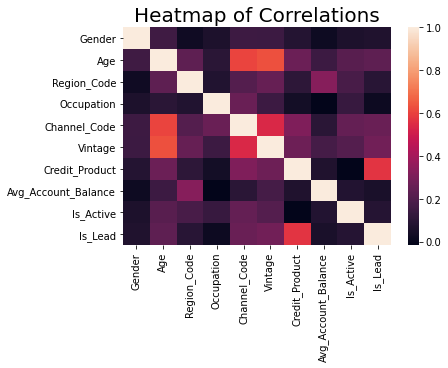

In [32]:
corr = data1.corr()
sns.heatmap(corr);
plt.title("Heatmap of Correlations", fontsize=20, fontweight=10);

In [33]:
# Fill missing values with 'mode'
#data['Credit_Product'].fillna(data['Credit_Product'].mode()[0], inplace=True)

# Train Test Split

In [34]:
# Split data into training & testing
train, test = train_test_split(data1, test_size=0.2, random_state=19, stratify=data1['Is_Lead'])
train.shape; test.shape

(196580, 10)

(49145, 10)

# Train Valdation split

In [35]:
train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
70131,1,62,5093,70173,2,68,0,395044,1,0
134841,0,64,19320,70173,2,44,0,687925,0,0
38686,0,56,1546,100886,1,25,2,1137562,0,0
149468,0,27,12826,71999,0,15,0,997253,1,0
208442,1,52,29416,100886,1,81,0,2768718,1,1


In [36]:
# Separate Features & Target
y = train['Is_Lead']
X = train.drop('Is_Lead',axis=1)
X.shape; y.shape

(196580, 9)

(196580,)

In [37]:
# Split data into training & validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=19)
X_train.shape; X_val.shape; y_train.shape; y_val.shape

(157264, 9)

(39316, 9)

(157264,)

(39316,)

# Model Building

In [38]:
# Model instances

lr = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier(max_depth=5, random_state=101, max_features=None, min_samples_leaf=15)
rfm = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1,
                             random_state=101, max_features=None, min_samples_leaf=15)
ab = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=14)          # base_estimator --> Decision tree (default)

# Multiple Models

In [40]:
algos = [lr, nb, knn, dtree, rfm, ab]
names =['Logistic Regression','Naive Bayes','KNN','Decision Tree','Random Forest', 'AdaBoost']

In [43]:
from sklearn.metrics import roc_curve

auc_list=[]
acc_list=[]
sensitivity=[]
specificity=[]
precision=[]
f1_score=[]
fpr_tpr = []

for name in algos:
    
    model = name
    model.fit(X_train,y_train)
    y_hat = model.predict(X_val)

    pred_prob = model.predict_proba(X_val)

    auc = roc_auc_score(y_true=y_val, y_score=pred_prob[:,1])
    fpr, tpr, _ = roc_curve(y_true=y_val, y_score=pred_prob[:,1])
    fpr_tpr.append({'Model': name, 'FPR':fpr, 'TPR':tpr})
#     fpr_tpr['Model'] = name
#     fpr_tpr['FPR'] = fpr
#     fpr_tpr['TPR'] = tpr
    
    acc = accuracy_score(y_true=y_val,y_pred=y_hat)
    TN, FP, FN, TP = confusion_matrix(y_true=y_val,y_pred=y_hat).ravel()

    sens = TP / (TP+FN)
    spec = TN / (TN+FP)       
    prec = TP / (TP+FP)
    f1 = 2*prec*sens / (prec + sens)

    auc_list.append(auc)          # AUC Score 
    acc_list.append(acc)          # Accuracy Score
    sensitivity.append(sens)      # Sensitivity/Recall 
    specificity.append(spec)      # Specificity 
    precision.append(prec)        # Precision
    f1_score.append(f1)           # F1 Score
    winsound.Beep(freq,duration)

LogisticRegression()

GaussianNB()

KNeighborsClassifier()

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, random_state=101)

RandomForestClassifier(max_features=None, min_samples_leaf=15, n_estimators=70,
                       n_jobs=-1, oob_score=True, random_state=101)

AdaBoostClassifier(learning_rate=1, random_state=14)

In [44]:
evaluation = pd.DataFrame({'Model': names,
                           'Accuracy Score':acc_list,
                           'AUC Score': auc_list,
                           'F1 Score': f1_score,
                           'Precision': precision,
                           'Sensitivity(Recall)': sensitivity,
                           'Specificity': specificity })
evaluation

,Model,Accuracy Score,AUC Score,F1 Score,Precision,Sensitivity(Recall),Specificity
0,Logistic Regression,0.766024,0.494604,0.053503,0.666667,0.027870,0.995665
1,Naive Bayes,0.756206,0.685858,0.143049,0.431034,0.085754,0.964785
2,KNN,0.720292,0.547143,0.181466,0.296883,0.130668,0.903725
3,Decision Tree,0.848611,0.861608,0.617432,0.771071,0.514846,0.952446
4,Random Forest,0.858226,0.867594,0.651973,0.780769,0.559653,0.951112
5,AdaBoost,0.854461,0.864747,0.619092,0.816793,0.498446,0.965218


# ROC plot

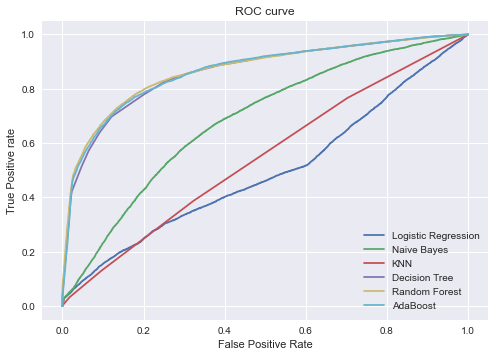

In [45]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Plot of ROC for each Alogorithm
for name, item in zip(names,fpr_tpr):
    plt.plot(item['FPR'], item['TPR'], label=name)
    
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**Conclusion:** Here `Decision Tree`, `Random Forest` and `AdaBoost` classifiers show almost similar `ROC` curves.